In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.draw as draw
import seaborn as sns

from src.model import Izhikevich
from src.network import Connectivity
from src.simulation import Simulation
from src.measure import Measure

C:\Users\User\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\User\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
filters = [[[0,0],[1,1]],
           [[0,1],[1,0]], 
           [[0,1],[0,1]], 
           [[1,0],[0,1]]]

def get_dissimilarity(img, filters, inds_sync):
    sim = Simulation(img, filters, 1, 0, 0)
    voltage, recovery, firings = sim.run(1000)
    
    measure = Measure(firings[inds_sync], 'victor_purpura')
    return measure.dissimilarity()

def get_end_coords(start_x, start_y, length, angle):
    if angle == 0:
        end_x, end_y = start_x, start_y + length
    elif angle == 90:
        end_x, end_y = start_x + length, start_y
    elif angle == 45:
        end_x, end_y = start_x + length, start_y + length
    return end_x, end_y

In [126]:
class Line_Square:
    def __init__(self, start_y, start_x, end_y, end_x):
        if end_x <= start_x:
            raise Exception('Please specify start_x < end_x')
        elif end_y <= start_y:
            raise Exception('Please specify start_y < end_y')
        if end_x - start_x != end_y - start_y:
            raise Exception('Please define a square region.')
            
        self.start_x = start_x
        self.end_x = end_x
        self.start_y = start_y
        self.end_y = end_y
        
    def draw(self):
        rr, cc = draw.line_nd((self.start_y, self.start_x), (self.end_y, self.end_x))
        return rr, cc

class Line_Square_0(Line_Square):
    def __init__(self, start_y, start_x, end_y, end_x, position='mid'):
        positions_available = ('up', 'down', 'mid')
        if position not in positions_available:
            raise Exception('Please select one of the available line positions: up, down or mid.')
            
        super().__init__(start_y, start_x, end_y, end_x)
        if position == 'mid':
            self.end_y = start_y + int((end_y-start_y) / 2)
            self.start_y = self.end_y
        elif position == 'up':
            self.end_y = start_y
        elif position == 'down':
            self.start_y = end_y
            
class Line_Square_45(Line_Square):
    def __init__(self, start_y, start_x, end_y, end_x, position='mid'):            
        super().__init__(start_y, start_x, end_y, end_x)
        
class Line_Square_90(Line_Square):
    def __init__(self, start_y, start_x, end_y, end_x, position='mid'):
        positions_available = ('left', 'right', 'mid')
        if position not in positions_available:
            raise Exception('Please select one of the available line positions: left, right or mid.')
            
        super().__init__(start_y, start_x, end_y, end_x)
        if position == 'mid':
            self.end_x = start_x + int((end_x-start_x) / 2)
            self.start_x = self.end_x
        elif position == 'left':
            self.end_x = start_x
        elif position == 'right':
            self.start_x = end_x   
            
class Line_Square_135(Line_Square):
    def __init__(self, start_y, start_x, end_y, end_x, position='mid'):            
        super().__init__(start_y, start_x, end_y, end_x)
        self.start_x, self.end_x = end_x, start_x

In [127]:
def line_45_joint(strength=1, length=3, width=18, height=18):
    angle_choices = {0: [45], 
                     45: [0, 90],
                     90: [45]}
    img = np.zeros(shape=(height,width))
    
    start_x, start_y = 0, 0
    end_x, end_y = length, length
    last_angle = 0
    
    while start_x < width-length and start_y < height-length: 
        angle = np.random.choice(angle_choices[last_angle])
        end_x, end_y = get_end_coords(start_x, start_y, length, angle)
        
        rr, cc = draw.line_nd((start_y, start_x), (end_y, end_x))
        img[rr, cc] = strength
        
        start_x, start_y = end_x, end_y 
        last_angle = angle
        
    if start_x < width or start_y < height:
        end_x, end_y = width-1, height-1
        rr, cc = draw.line_nd((start_y, start_x), (end_y, end_x))
        img[rr, cc] = strength
    
    return img

In [181]:
def line_45_disjoint(strength=1, length=3, width=18, height=18):
    all_x_start = list(range(0,width,length))
    all_x_end = list(range(length,width,length)) + [width-1]
    all_y_start = list(range(0,height,length))
    all_y_end = list(range(length,height,length)) + [height-1]
    
    angles = {0: {'choice': [45], 'class': Line_Square_0}, 
              45: {'choice': [0, 90], 'class': Line_Square_45},
              90: {'choice': [45], 'class': Line_Square_90},
              -1: {'choice': [0, 45, 90]}}
    img = np.zeros(shape=(height,width))
    last_angle = -1
    
    for start_y, start_x, end_y, end_x in zip(all_y_start, all_x_start, all_y_end, all_x_end):
        angle = np.random.choice(angles[last_angle]['choice'])
        
        rr, cc = angles[angle]['class'](start_y, start_x, end_y, end_x).draw()
        img[rr, cc] = strength
        last_angle = angle

    return img

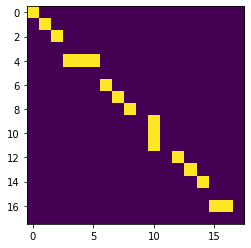

In [201]:
width = 18
height = 18
strength = 1
length = 3

img = line_45_disjoint(width=width, height=height, strength=strength, length=length)
plt.imshow(img)
plt.show()

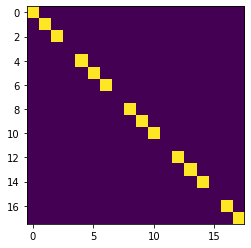

In [202]:
inp_strength = 1
height, width = 18, 18
img1 = np.zeros(shape=(height,width))

rr, cc = draw.line_nd((0, 0), (height, width))  
img1[rr, cc] = inp_strength

for y,x in zip(range(length,height,length+1), range(length,width,length+1)):
    img1[y, x] = 0

plt.imshow(img1)
plt.show()

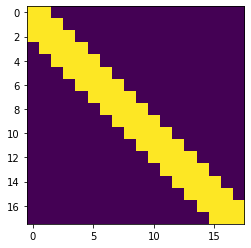

272

In [217]:
inds_sync = np.zeros(shape=(height,width))

for i in range(width):
    x_start = max(0,i-2)
    x_end = i+2
    y = i
    inds_sync[y,x_start:x_end] = 1

plt.imshow(inds_sync)
plt.show()

inds_sync = inds_sync.reshape(-1).nonzero()[0]
inds_sync = np.concatenate([inds_sync+(i*np.prod(img.shape)) for i in range(4)])
len(inds_sync)

In [210]:
get_dissimilarity(img, filters, inds_sync)

Simulated 100 ms of braintime in 0.04048039999906905 s of computer time.
Simulated 200 ms of braintime in 0.0749156999954721 s of computer time.
Simulated 300 ms of braintime in 0.10657249999349006 s of computer time.
Simulated 400 ms of braintime in 0.1375361999962479 s of computer time.
Simulated 500 ms of braintime in 0.16730769999412587 s of computer time.
Simulated 600 ms of braintime in 0.1985685999970883 s of computer time.
Simulated 700 ms of braintime in 0.23190049999539042 s of computer time.
Simulated 800 ms of braintime in 0.26796489999833284 s of computer time.
Simulated 900 ms of braintime in 0.3015382999947178 s of computer time.
Simulation took 0.3332846999983303 s
272 spike trains to compare


{'median': 0.0, 'mean': 1.3510004069893642, 'max': 23.0, 'min': 0.0}

In [211]:
get_dissimilarity(img1, filters, inds_sync)

Simulated 100 ms of braintime in 0.056607400001666974 s of computer time.
Simulated 200 ms of braintime in 0.11204300000099465 s of computer time.
Simulated 300 ms of braintime in 0.16177089999837335 s of computer time.
Simulated 400 ms of braintime in 0.20628120000037597 s of computer time.
Simulated 500 ms of braintime in 0.2548540999996476 s of computer time.
Simulated 600 ms of braintime in 0.3007251000017277 s of computer time.
Simulated 700 ms of braintime in 0.3643262000041432 s of computer time.
Simulated 800 ms of braintime in 0.42242999999871245 s of computer time.
Simulated 900 ms of braintime in 0.46686359999876004 s of computer time.
Simulation took 0.5202247999986866 s
272 spike trains to compare


{'median': 0.0, 'mean': 1.044885337529846, 'max': 24.0, 'min': 0.0}

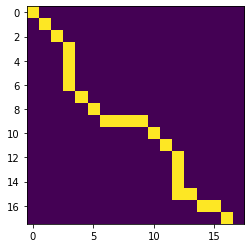

In [241]:
width = 18
height = 18
strength = 1
length = 3

img2 = line_45_joint(width=width, height=height, strength=strength, length=length)
plt.imshow(img2)
plt.show()

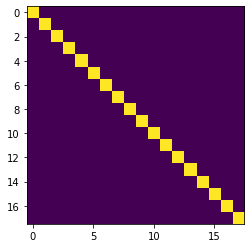

In [242]:
inp_strength = 1
height, width = 18, 18
img3 = np.zeros(shape=(height,width))

rr, cc = draw.line_nd((0, 0), (height, width))  
img3[rr, cc] = inp_strength

plt.imshow(img3)
plt.show()

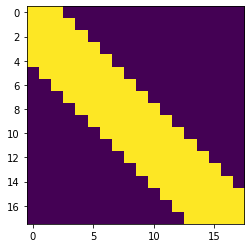

452

In [243]:
inds_sync1 = np.zeros(shape=(height,width))

for i in range(width):
    x_start = max(0,i-4)
    x_end = i+3
    y = i
    inds_sync1[y,x_start:x_end] = 1

plt.imshow(inds_sync1)
plt.show()

inds_sync1 = inds_sync1.reshape(-1).nonzero()[0]
inds_sync1 = np.concatenate([inds_sync1+(i*np.prod(img.shape)) for i in range(4)])
len(inds_sync1)

In [244]:
get_dissimilarity(img2, filters, inds_sync1)

Simulated 100 ms of braintime in 0.0633391000010306 s of computer time.
Simulated 200 ms of braintime in 0.1238865999985137 s of computer time.
Simulated 300 ms of braintime in 0.18036800000118092 s of computer time.
Simulated 400 ms of braintime in 0.22780580000107875 s of computer time.
Simulated 500 ms of braintime in 0.27559080000355607 s of computer time.
Simulated 600 ms of braintime in 0.3653395000001183 s of computer time.
Simulated 700 ms of braintime in 0.4231781999988016 s of computer time.
Simulated 800 ms of braintime in 0.48107660000096075 s of computer time.
Simulated 900 ms of braintime in 0.5371626999985892 s of computer time.
Simulation took 0.5893218999990495 s
452 spike trains to compare


{'median': 0.0, 'mean': 1.601891097462865, 'max': 24.0, 'min': 0.0}

In [247]:
get_dissimilarity(img3, filters, inds_sync1)

Simulated 100 ms of braintime in 0.15201400000660215 s of computer time.
Simulated 200 ms of braintime in 0.25211339999805205 s of computer time.
Simulated 300 ms of braintime in 0.3220750000036787 s of computer time.
Simulated 400 ms of braintime in 0.38531550001061987 s of computer time.
Simulated 500 ms of braintime in 0.43034459999762475 s of computer time.
Simulated 600 ms of braintime in 0.47666870000830386 s of computer time.
Simulated 700 ms of braintime in 0.5186874000064563 s of computer time.
Simulated 800 ms of braintime in 0.5666823000065051 s of computer time.
Simulated 900 ms of braintime in 0.6113186000002315 s of computer time.
Simulation took 0.6604808999982197 s
452 spike trains to compare


{'median': 0.0, 'mean': 1.2329793968172988, 'max': 25.0, 'min': 0.0}

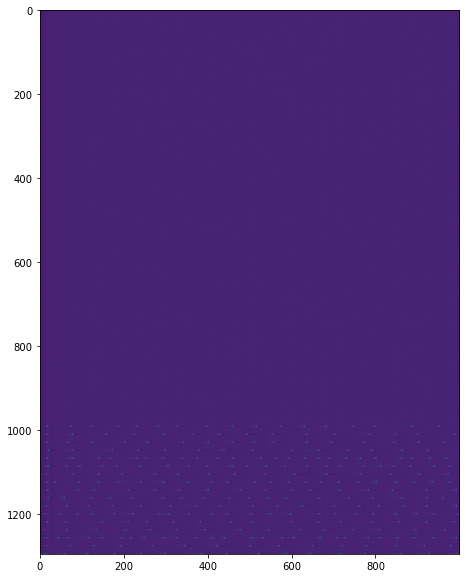

In [139]:
voltage_out = voltage.copy()
voltage_out[voltage_out >= 30] = 30

h, w = voltage_out.shape

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(voltage_out) 
#plt.colorbar()

#ax.set_aspect(w/h)
plt.show()

In [ ]:
def firing_stats(firings):
    if not isinstance(firings, np.ndarray):
        firings = np.array(firings)
    if len(firings.shape) == 1:
        firings_count = firings.sum()
        return firings.sum()
        
    firings_count = firings.sum(1)
    return {'max': np.max(firings_count), 'min': np.min(firings_count), 'mean': np.mean(firings_count), 'median': np.median(firings_count)}